In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import datetime
import numpy as np
from erddapy import ERDDAP
from argopy import DataFetcher as ArgoDataFetcher
plt.rcParams.update({'font.size': 14})


# Get nearest argo floats to glidermission

### 1. Download glider datasets from our own ERDDAP

In [21]:
# Setup initial ERDDAP connection
e = ERDDAP(
  server="https://erddap.observations.voiceoftheocean.org/erddap",
  protocol="tabledap",
)

In [23]:
# Fetch dataset list
e.response = "csv"
e.dataset_id = "allDatasets"
df_datasets = e.to_pandas()


In [6]:
datasets = df_datasets.datasetID
# Select only nrt datasets
nrt_datasets = datasets[datasets.str[:3] == "nrt"].values

In [7]:
# Specify variables of interest
e.variables = [
    "latitude",
    "longitude",
    "salinity",
    "temperature",
    "time",
    "pressure"
]

# Download each dataset and save as xarray
glider_datasets = {}
for ds_name in nrt_datasets:
    e.dataset_id = ds_name
    ds = e.to_xarray()
    glider_datasets[ds_name] = ds

In [31]:
def format_difference(deg_e, deg_n, ns_ahead):
    """
    Pretty formatting for a lon, lat, time difference between two points
    """
    km_n = (111 * deg_n).round(1)
    km_e = (111 * deg_e * np.cos(np.deg2rad(deg_n))).round(1)
    h_ahead = (np.float64(ns_ahead) / (1e9 * 60 * 60)).round(1)
    if km_n > 0:
        north_str = f"{km_n} km N"
    else:
        north_str = f"{-km_n} km S"
    if km_e > 0:
        east_str = f"{km_e} km E"
    else:
        east_str = f"{-km_e} km W"
    if h_ahead > 0:
        time_str = f"{h_ahead} hours later"
    else:
        time_str = f"{-h_ahead} hours earlier"
    return east_str, north_str, time_str


### 2. Find nearest argo profile for each glidermission

We can set tolerances for how close an argo profile must be in time and space

In [ ]:
def nearest_argo_profile(ds_glider, lat_window=0.5, lon_window=1, time_window = np.timedelta64(7, "D")):
    """
    Finds the nearest argo profile to a supplied glidermission. Uses ifremer ERDDAP
    """
    mean_lon = ds_glider.longitude.mean().values
    mean_lat = ds_glider.latitude.mean().values
    mean_time = ds_glider.time.mean().values
    max_pressure = ds_glider.pressure.values.max()
    min_time = str(mean_time-time_window)[:10]
    max_time = str(mean_time+time_window)[:10]
    search_region = [mean_lon-lon_window, mean_lon+lon_window, 
                 mean_lat-lat_window, mean_lat+lat_window,
                 0, max_pressure,
                 min_time, max_time]
    try:
        ds = ArgoDataFetcher(src='erddap').region(search_region).to_xarray()
        ds2 = ds.argo.point2profile()
        closest_time_index = np.abs(ds2.TIME.values-mean_time).argmin()
        profile = ds2.isel({"N_PROF":closest_time_index})
        deg_n = profile.LATITUDE.values - np.nanmean(ds_glider.latitude)
        deg_e = profile.LONGITUDE.values - np.nanmean(ds_glider.longitude)
        ns_ahead = profile.TIME.values - ds_glider.time.mean()
        east_diff, north_diff, time_diff = format_difference(deg_e, deg_n, ns_ahead)
        loc_str = f"Nearest float is {east_diff}, {north_diff} & {time_diff} than mean of glider data"
        print(loc_str)
        return profile
    except:
        print("No floats found within tolerances")
        return None
    

In [34]:
argo_datasets = {}
for name, ds in glider_datasets.items():
    print(f"Trying dataset {name}")
    argo_datasets[name] = nearest_argo_profile(ds)
fail, success = 0, 0
for val in argo_datasets.values():
    if val:
        success+=1
    else:
        fail+=1
print(f"\nsuccess: {success}, fail: {fail}")  

Trying dataset nrt_SEA068_M27
No floats found within tolerances
Trying dataset nrt_SEA069_M9
No floats found within tolerances
Trying dataset nrt_SEA055_M31
Nearest float is 23.9 km W, 3.9 km N & 21.2 hours earlier than mean of glider data
Trying dataset nrt_SEA055_M33
No floats found within tolerances
Trying dataset nrt_SEA055_M35
No floats found within tolerances
Trying dataset nrt_SEA055_M37
Nearest float is 17.0 km E, 4.8 km N & 4.5 hours later than mean of glider data
Trying dataset nrt_SEA055_M39
No floats found within tolerances
Trying dataset nrt_SEA055_M41
No floats found within tolerances
Trying dataset nrt_SEA055_M43
Nearest float is 25.2 km E, 26.8 km N & 4.5 hours earlier than mean of glider data
Trying dataset nrt_SEA045_M54
Nearest float is 11.2 km W, 11.3 km N & 9.5 hours earlier than mean of glider data
Trying dataset nrt_SEA045_M56
Nearest float is 28.4 km W, 1.3 km S & 15.3 hours earlier than mean of glider data
Trying dataset nrt_SEA045_M60
No floats found within to

### 3. Create scatter plots to compare the temperature and salinity of the glider and its nearest float

We can sanity check our data by visual inspection. A more reliable test would be some form of statistical comparison of the two datasets.

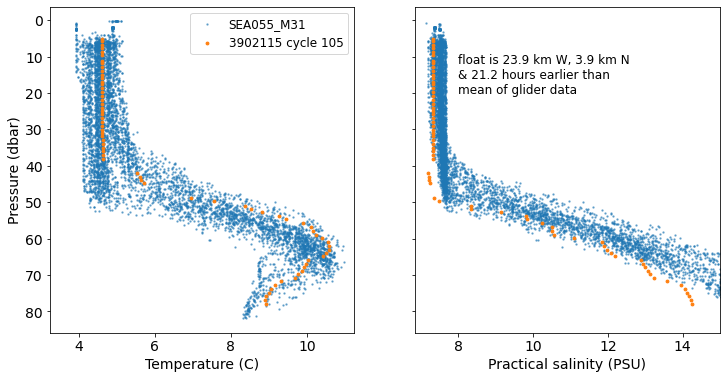

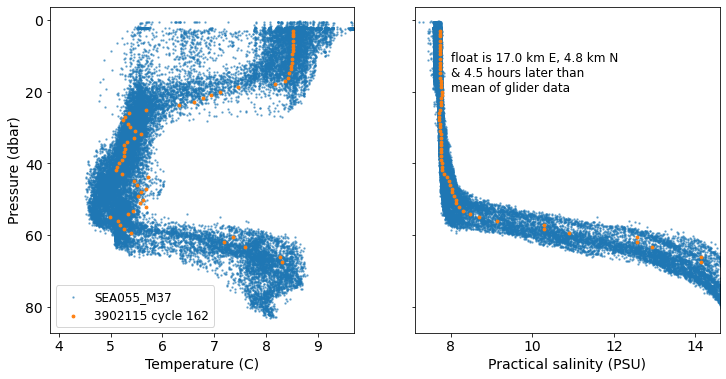

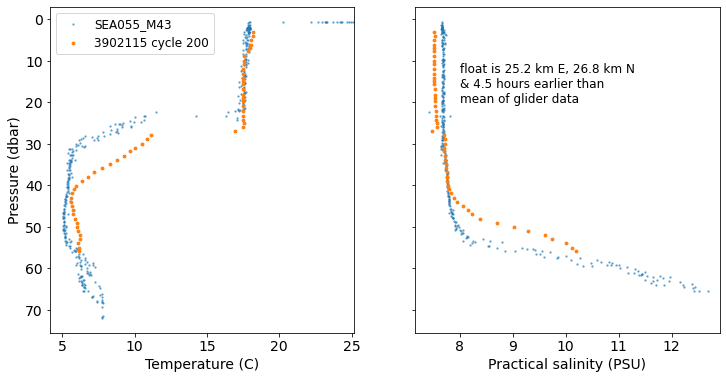

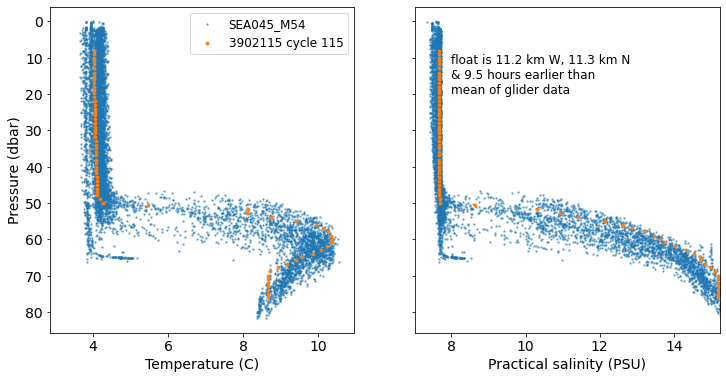

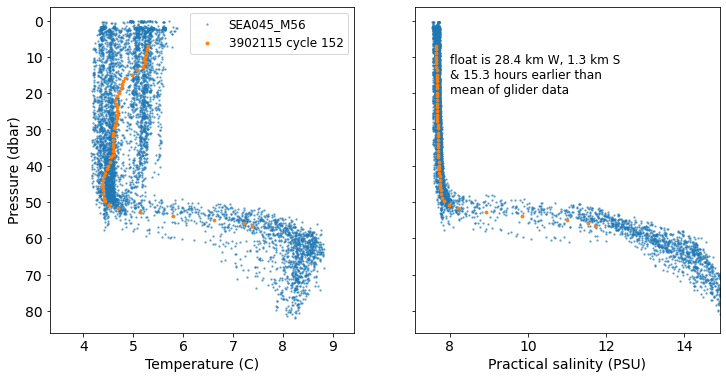

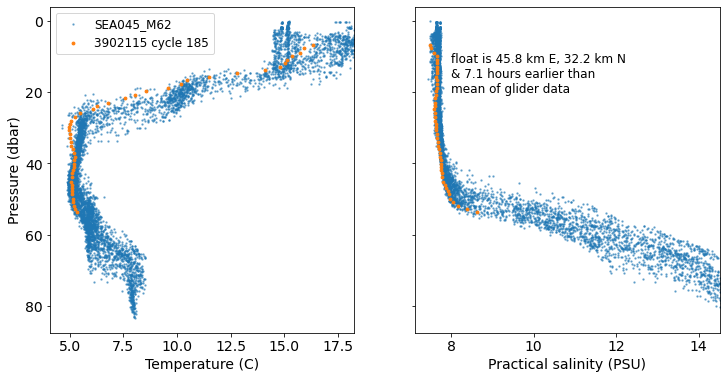

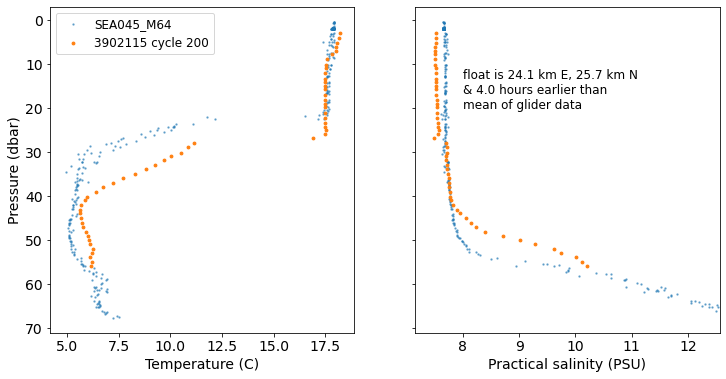

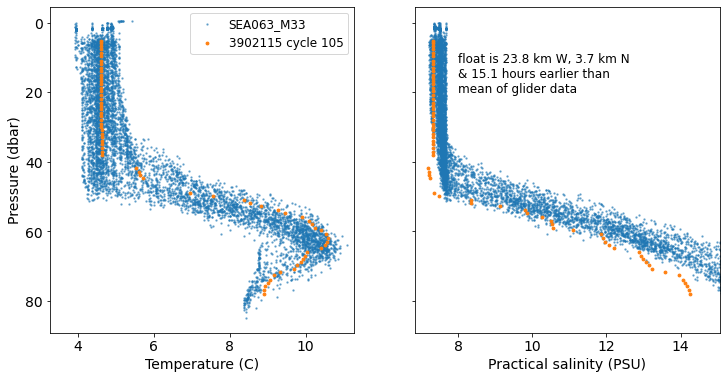

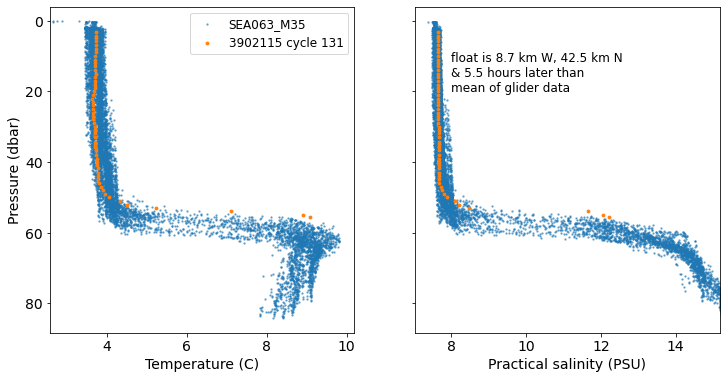

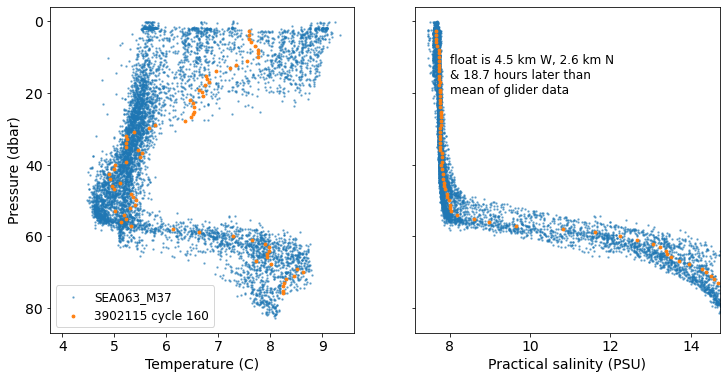

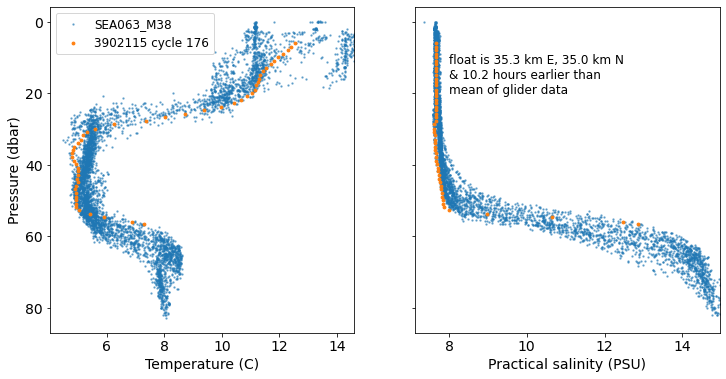

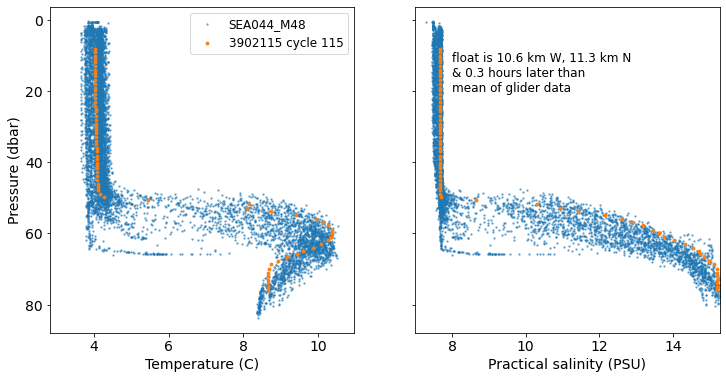

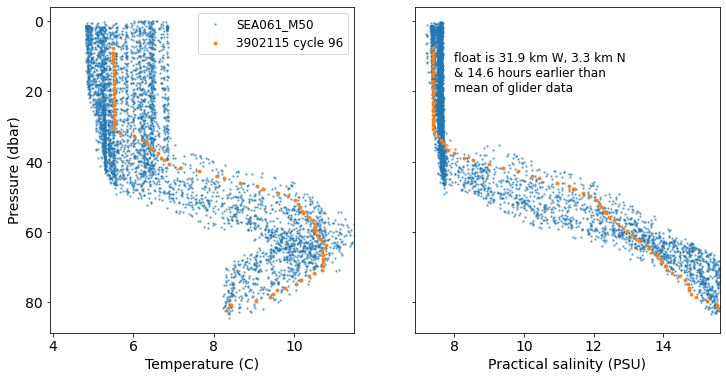

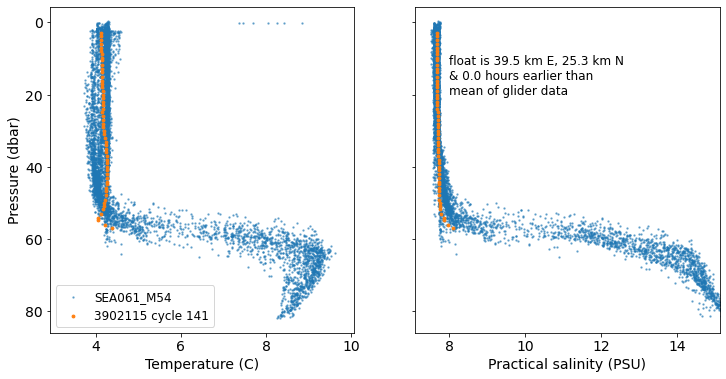

In [35]:
def compare_scatter(name, ds_glider, ds_argo):
    """
    Create scatter plots of temperature and salinity to visually compare glider and argo float data
    """
    fig, ax = plt.subplots(1,2, sharey="row", figsize=(12, 6))
    ax = ax.ravel()
    argo_name = f"{int(ds_argo.PLATFORM_NUMBER)} cycle {int(ds_argo.CYCLE_NUMBER)}"
    temp_lim = [np.nanpercentile(ds_glider.temperature,5)-1, np.nanpercentile(ds_glider.temperature,95)+1]
    ax[0].scatter(ds_glider.temperature, ds_glider.pressure, s=2, label=name[4:], alpha=0.5)
    ax[0].scatter(ds_argo.TEMP, ds_argo.PRES, s=8, label=argo_name)
    ax[0].invert_yaxis()
    ax[0].set(ylabel="Pressure (dbar)", xlabel="Temperature (C)", xlim=temp_lim)
    sal_lim = [np.nanpercentile(ds_glider.salinity,5)-0.5, np.nanpercentile(ds_glider.salinity,95)+0.5]
    ax[1].scatter(ds_glider.salinity, ds_glider.pressure, s=2, alpha=0.5)
    ax[1].scatter(ds_argo.PSAL, ds_argo.PRES, s=8)
    ax[1].set(xlabel="Practical salinity (PSU)", xlim=sal_lim)
    ax[0].legend(fontsize=12)
    
    deg_n = ds_argo.LATITUDE.values - np.nanmean(ds_glider.latitude)
    deg_e = ds_argo.LONGITUDE.values - np.nanmean(ds_glider.longitude)
    ns_ahead = ds_argo.TIME.values - ds_glider.time.mean()
    east_diff, north_diff, time_diff = format_difference(deg_e, deg_n, ns_ahead)
    loc_str = f"float is {east_diff}, {north_diff}\n& {time_diff} than \nmean of glider data"
    loc_str
    ax[1].text(8, 20, loc_str, fontsize=12)
    
    plt.savefig(f"figures/{name}.png")
    #plt.close("all")

for name, ds_argo in argo_datasets.items():
    if ds_argo:
        compare_scatter(name, glider_datasets[name], ds_argo)